In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [2]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 535) # 535 is the 25% of the frames

100%|█████████████████████████████████████████| 534/534 [00:08<00:00, 63.43it/s]


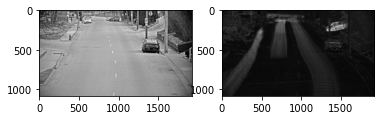

In [3]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [258]:
def closing(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def opening(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)


def getBoxesFromMask2(mask):
    # output = cv2.connectedComponentsWithStats(np.uint8(mask), 8, cv2.CV_32S)
    # (numLabels, labels, boxes, centroids) = output
    counts, hier = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    detectedElems = []
    for cont in counts: #First box is always the background
        x,y,w,h = cv2.boundingRect(cont)
        
        if 29 < w < 593 and 12 < h < 442: #Condition based on GT minimums* and maximums
            if 0.4 < w/h < 2.5: #Condition to avoid too elongated boxes
                b = VehicleDetection(0, -1, float(x), float(y), float(w), float(h), float(-1))
                detectedElems.append(b)

    return detectedElems


def remove_background2(means, stds, videoPath, ROIpath, alpha=4, sigma=2):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            img_gray = cv2.medianBlur(img_gray, 7)
            
            img_mask = np.zeros(img_gray.shape, dtype = np.uint8)
            img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            roi_applied = cv2.bitwise_and(img_mask, roi)
            
            cleaned = opening(roi_applied, 5, 5) #initial removal of small noise
            cleaned = closing(cleaned, 1, 80) #vertical filling of areas
            cleaned = closing(cleaned, 80, 1) #horizontal filling of areas
            cleaned = closing(cleaned, 40, 1) # 2nd horizontal filling of areas
            cleaned = closing(cleaned, 80, 80) #general filling
            cleaned = opening(cleaned, 10, 60) #final cleaning
            
            cv2.imwrite(f'./masks/mask_{frame}.png', cleaned)

            detections[str(frame)] = getBoxesFromMask2(cleaned)
            cleaned = cv2.cvtColor(cleaned,cv2.COLOR_GRAY2RGB)
            for b in detections[str(frame)]:
                tl = (int(b.xtl), int(b.ytl))
                br = (int(b.xbr), int(b.ybr))
                color = (255,0,0)
                cleaned = cv2.rectangle(cleaned, tl, br, color, 2)
            cv2.imwrite(f'./masks_bb/mask_{frame}.png', cleaned)

    return detections

In [259]:
singleGaussianDetections = remove_background2(means, stds, data_path + 'vdo.avi', data_path + 'roi.jpg', 4, 2.0)

100%|███████████████████████████████████████| 2141/2141 [04:19<00:00,  8.25it/s]


In [260]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [261]:
gt_notParked = {}
for frame, objs in gt_detect.items():
    obj_notParked = []
    for ob in objs:
        if not ob.parked:
            obj_notParked.append(ob)
    if len(obj_notParked) > 0:
        gt_notParked[frame] = obj_notParked

In [262]:
#split detections in groups of frames
detects_1000 = {}
for frame in range(530,1000):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000[str(frame)] = singleGaussianDetections[str(frame)]

detects_1000_1500 = {}
for frame in range(1000,1500):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1000_1500[str(frame)] = singleGaussianDetections[str(frame)]

detects_1500_end = {}
for frame in range(1500,2142):
    if str(frame) in singleGaussianDetections and len(singleGaussianDetections[str(frame)]) > 0:
        detects_1500_end[str(frame)] = singleGaussianDetections[str(frame)]

In [263]:
#split detections in groups of frames
gt_1000 = {}
for frame in range(530,1000):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1000[str(frame)] = gt_notParked[str(frame)]

gt_1000_1500 = {}
for frame in range(1000,1500):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1000_1500[str(frame)] = gt_notParked[str(frame)]

gt_1500_end = {}
for frame in range(1500,2142):
    if str(frame) in gt_notParked and len(gt_notParked[str(frame)]) > 0:
        gt_1500_end[str(frame)] = gt_notParked[str(frame)]

In [264]:
recs, precs, aps = ap_wo_conf(gt_1000,detects_1000)
recs2, precs2, aps2 = ap_wo_conf(gt_1000_1500,detects_1000_1500)
recs3, precs3, aps3 = ap_wo_conf(gt_1500_end,detects_1500_end)
recs4, precs4, aps4 = ap_wo_conf(gt_notParked,singleGaussianDetections)


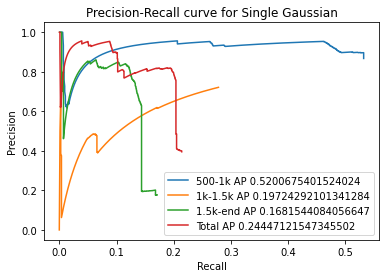

In [265]:
tests = [np.mean(precs, axis=0), np.mean(precs2, axis=0), np.mean(precs3, axis=0), np.mean(precs4, axis=0)]
labels = [f'500-1k AP {np.mean(aps)}', f'1k-1.5k AP {np.mean(aps2)}', f'1.5k-end AP {np.mean(aps3)}', f'Total AP {np.mean(aps4)}']
plot_multiple_prec_recall_curves(tests, [recs[0], recs2[0], recs3[0], recs4[0]], labels, f'Precision-Recall curve for Single Gaussian')

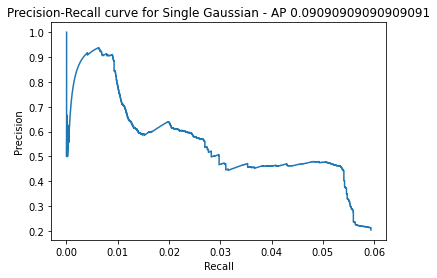

In [21]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

In [13]:
alphas = np.linspace(2.0, 15.0, num=8)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background2(means,stds, data_path + 'vdo.avi', data_path + 'roi.jpg', alpha, 2.0)
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha:.2f}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian - AP {ap}')

 38%|███████████████                         | 808/2141 [00:17<00:29, 45.22it/s]


KeyboardInterrupt: 

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector500-1000', 536, 1000)

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1000-1500', 1000, 1500)

In [ ]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetector1500-2000', 1500, 2140)